In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import json
import csv
from tqdm import tqdm_notebook
import pickle
import time
import nltk
import re
import string
import unicodedata
from timeit import default_timer as timer

import keras

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing

from hyperopt import STATUS_OK, hp, tpe, fmin, Trials
from hyperopt.pyll.stochastic import sample
from hyperopt.pyll.base import scope

import matplotlib.pyplot as plt
sns.set_context('notebook')

Using TensorFlow backend.


# Yummly Dataset

Objective: predict the cuisine based on the list of ingredients.

Learning Goal: apply the techniques learned from the previous Titanic exercise with the addition of working with text data, apply dimensionality reduction techniques.

## Exploratory Data Analysis

In [2]:
df_train_0 = pd.read_json('data/train.json')
df_test_0 = pd.read_json('data/test.json')

display(df_train_0.head())

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [3]:
np.shape(df_train_0)

(39774, 3)

Check for any nulls.

In [4]:
print(df_train_0.isnull().sum())
print(df_test_0.isnull().sum())

df_train = df_train_0.copy()
df_test = df_test_0.copy()

cuisine        0
id             0
ingredients    0
dtype: int64
id             0
ingredients    0
dtype: int64


How many ingredients are there for each recipe?

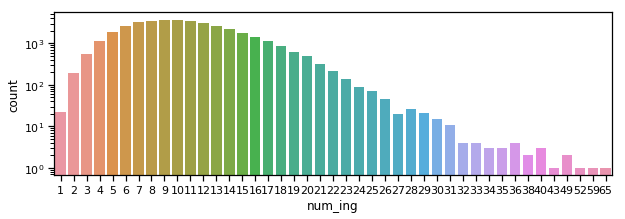

In [5]:
df_train['num_ing'] = df_train['ingredients'].apply(lambda x: len(x))
df_test['num_ing'] = df_test['ingredients'].apply(lambda x: len(x))
plt.figure(1, figsize=(10,3))
s = sns.countplot(x='num_ing', data=df_train)
s.set_yscale('log')

It's weird that there are single ingredient "recipes" but they still contain useful information about each cuisine.

In [6]:
display(df_train.loc[df_train.num_ing < 2])

,cuisine,id,ingredients,num_ing
940,japanese,4734,[sushi rice],1
2088,vietnamese,7833,[dried rice noodles],1
6787,indian,36818,[plain low-fat yogurt],1
7011,indian,19772,[unsalted butter],1
8181,japanese,16116,[udon],1
8852,thai,29738,[sticky rice],1
8990,indian,41124,[butter],1
10506,mexican,32631,[corn tortillas],1
13178,thai,29570,[grained],1
17804,southern_us,29849,[lemonade concentrate],1


What's the recipe with >60 ingredients?!

In [7]:
display(df_train.loc[df_train.num_ing > 60])

,cuisine,id,ingredients,num_ing
15289,italian,3885,"[fettucine, fresh marjoram, minced garlic, oli...",65


In [8]:
gtr_60_ind = df_train[df_train['num_ing'] > 60].index.values
print(df_train.ingredients[gtr_60_ind].tolist())

[['fettucine', 'fresh marjoram', 'minced garlic', 'olive oil', 'garlic powder', 'large eggs', 'Alfredo sauce', 'vegetable oil', 'cajun seasoning', 'shredded romano cheese', 'basil dried leaves', 'salt', 'cayenne pepper', 'scallions', 'red bell pepper', 'boneless skinless chicken breast halves', 'soba', 'pasta sauce', 'kosher salt', 'milk', 'fresh ginger', 'ground black pepper', 'flour', 'cooked chicken', 'coarse salt', 'lemon', 'diced tomatoes', 'garlic', 'rice vinegar', 'Neufchâtel', 'garlic cloves', 'dried parsley', 'frozen artichoke hearts', 'penne', 'pepper', 'sweet onion', 'part-skim mozzarella cheese', 'parmigiano reggiano cheese', 'basil leaves', 'onion powder', 'red wine vinegar', 'red pepper flakes', 'orzo', 'crushed red pepper', 'all-purpose flour', 'freshly ground pepper', 'sliced mushrooms', 'panko breadcrumbs', 'plum tomatoes', 'fresh basil', 'fresh leav spinach', 'water', 'sun-dried tomatoes', 'ground pepper', 'grated parmesan cheese', 'boneless skinless chicken breasts',

This seems like a totally weird recipe. It calls for 'boneless skinless chicken breast halves', 'cooked chicken', 'chicken cutlets', and 'boneless skinless chicken breasts.' Here's another recipe with suspiciously high number of ingredients, and an even more suspicious ingredient list.

In [9]:
display(df_train.loc[df_train.num_ing > 40])
print(df_train.ingredients[26103])

,cuisine,id,ingredients,num_ing
10513,mexican,49282,"[condensed cream of chicken soup, pepper, refr...",49
15289,italian,3885,"[fettucine, fresh marjoram, minced garlic, oli...",65
22906,indian,2253,"[white vinegar, sparkling lemonade, coconut su...",49
26103,mexican,13049,"[vanilla ice cream, lime, garlic powder, zucch...",52
30350,brazilian,13430,"[marshmallows, fresh corn, cheddar cheese, shr...",59
31250,italian,29216,"[eggs, warm water, pepper, dried basil, unsalt...",43


['vanilla ice cream', 'lime', 'garlic powder', 'zucchini', 'guacamole', 'chili powder', 'red wine vinegar', 'paprika', 'purple onion', 'yellow onion', 'fresh parsley leaves', 'fresh mint', 'cumin', 'eggs', 'black beans', 'honey', 'asparagus', 'sugar cookie dough', 'boneless skinless chicken breasts', 'zesty italian dressing', 'red pepper flakes', 'crushed red pepper flakes', 'cilantro leaves', 'cayenne pepper', 'fudge brownie mix', 'corn tortillas', 'avocado', 'black pepper', 'chocolate chip cookie mix', 'ground pepper', 'Sriracha', 'condiments', 'onion powder', 'butter', 'cilantro', 'salt', 'flat iron steaks', 'lemon juice', 'sour cream', 'green bell pepper', 'kosher salt', 'olive oil', 'pepper jack', 'jalapeno chilies', 'flank steak', 'vegetable oil', 'portabello mushroom', 'yellow bell pepper', 'salsa', 'garlic cloves', 'red bell pepper', 'candy']


Based on the distribution of number of ingredients, let's make a cut on rows with number of ingredients > 31. For every number of ingredients exceeding 31, there are fewer than 10 recipes each, so we're throwing out fewer than ~100 rows out of close to 40000 rows. We want to be conservative with these cut because we don't want to bias against cuisines that use a lot of ingredients.

In [10]:
df_train = df_train[df_train['num_ing'] < 32]

In [11]:
df_train.reset_index(inplace=True, drop=True)

Now, moving on to the cuisines themselves: italian and Mexican cuisines are the top two popular categories. There's moderate class imbalance.

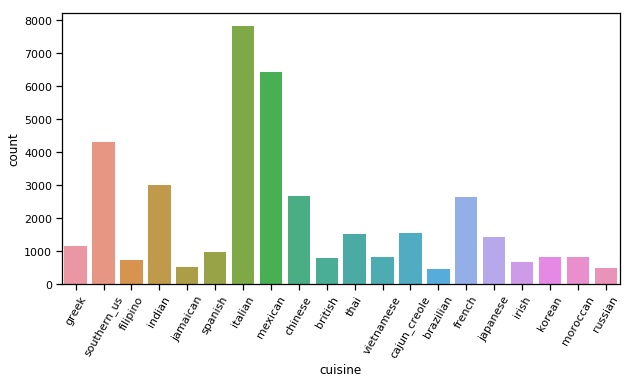

In [12]:
plt.figure(1, figsize=(10,5))
s = sns.countplot(x='cuisine', data=df_train)
dummy = s.set_xticklabels(s.get_xticklabels(), rotation=60)

Let's preprocess the ingredient names. We will first pass the ingredients through a lemmatizer to return the lemma, or the base of the word.

In [13]:
lemmatizer = nltk.WordNetLemmatizer()
#tomatoes would be modified to tomato
print(lemmatizer.lemmatize('tomatoes'))

tomato


In [14]:
def ingredients(df, i):
    ing_list = df['ingredients'].iloc[i].copy()

    ing_concat = []
    for ing in ing_list:
        #replace accent characters, copied directly from (https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-in-a-python-unicode-string)
        ing = u"".join([c for c in unicodedata.normalize('NFKD', ing) if not unicodedata.combining(c)])
        #remove alphabet characters, e.g., numbers, special characters
        ing = re.sub(r'[^a-zA-Z]',' ', ing)

        #this was included later. RF features analysis shows this as an important feature.
        #turn this into one word so it wont be separated into "fish" and "sauce."
        #ignore prefixes such as "thai" and "asian."
        if 'fish sauce' in ing:
            ing = 'fishsauce'
        #similarly for corn starch and sour cream
        if 'corn starch' in ing:
            ing = 'cornstarch'
        if 'sour cream' in ing:
            ing = 'sourcream'

        word_list = ing.split()
        for word in word_list:
            word = word.strip()
            lem = lemmatizer.lemmatize(word)
            ing_concat.append(lem)
    ing_concat = list(np.unique(ing_concat))
    df.at[i, 'ingredients_concat'] = ' '.join(ing_concat) 


In [15]:
for i in range(df_train.shape[0]):
    ingredients(df_train, i) 
for i in range(df_test.shape[0]):
    ingredients(df_test, i) 

Get the simple counts of words from the ingredients.

In [16]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df_train.ingredients_concat)
X_test_counts = count_vect.transform(df_test.ingredients_concat)
print('A total of', X_train_counts.shape[0], 'recipes')
print('A total of', X_train_counts.shape[1], 'unique ingredient words')

A total of 39745 recipes
A total of 2811 unique ingredient words


Some of the most common ingredients include things like salt, onions, oil, and water.

In [17]:
ingredient_names = np.array(count_vect.get_feature_names())
ingredient_counts = dict(zip(ingredient_names, X_train_counts.sum(axis=0).tolist()[0]))
ingredient_counts = pd.DataFrame(list(ingredient_counts.items()), columns=['ingredients', 'counts'])
ingredient_counts['counts_frac'] = ingredient_counts['counts'].apply(lambda x: x/X_train_counts.shape[0])

In [18]:
ingredient_counts.sort_values(by='counts', ascending=False).head(n=10)

,ingredients,counts,counts_frac
2191,salt,23667,0.595471
1740,oil,21087,0.530557
1868,pepper,20156,0.507133
1005,garlic,18205,0.458045
1752,onion,17593,0.442647
1112,ground,13108,0.329802
960,fresh,13098,0.329551
1747,olive,11232,0.282602
2474,sugar,11082,0.278828
224,black,10140,0.255126


Now apply TF-IDF. Instead of simple counts of ingredients in each recipe, this approach takes into account that some ingredients appear very frequently (e.g., salt) and therefore contain less discriminating power. 

In [19]:
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_counts)
X_test_tfidf = tfidf.transform(X_test_counts)
print(X_train_tfidf.shape)

(39745, 2811)


Encode the cuisine names.

In [20]:
mlb = preprocessing.MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform(df_train.cuisine.values.reshape(-1,1))

le = preprocessing.LabelEncoder()
y_train_le = le.fit_transform(df_train.cuisine)

## Dimensionality Reduction

There are close to 2800 features, which is a fairly large number. We can try applying some dimensionality reduction techniques to select only features with some predictive power and decrease the computation time. Techniques we will explore are:

* low variance filter
* random forest regressor feature importance
* principle component analysis


In [21]:
X_train_tfidf_pd = pd.DataFrame(X_train_tfidf.A, columns=ingredient_names)
X_test_tfidf_pd = pd.DataFrame(X_test_tfidf.A, columns=np.array(count_vect.get_feature_names()))

#### Low variance filter
One method is to drop variables with low variance across the samples in the data set.

In [22]:
var = X_train_tfidf_pd.var()
var.sort_values(ascending=False).head(n=10)

flour      0.004776
butter     0.004710
water      0.004628
egg        0.004623
sugar      0.004607
milk       0.004508
purpose    0.004280
all        0.004279
white      0.004277
juice      0.004265
dtype: float64

In [23]:
var.sort_values(ascending=True).head(n=10)

psyllium     0.000002
teff         0.000002
slim         0.000002
cotto        0.000002
romanesco    0.000003
veri         0.000003
pat          0.000003
leaves       0.000003
better       0.000003
than         0.000003
dtype: float64

We could cut the number of features by about 60% if we throw out features with $\log{\sigma} \lesssim -4$. But this choice of threshold is somewhat arbitrary and we'd have to test several options.

(-6.4, -2.4)

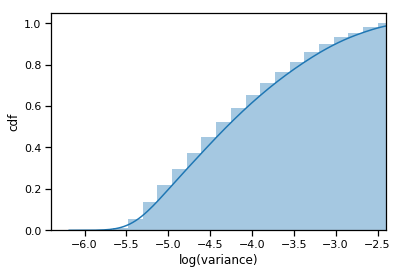

In [24]:
s = sns.distplot(np.log10(var), hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
s.set_ylabel('cdf')
s.set_xlabel('log(variance)')
s.set_xlim(-6.4,-2.4)

#### RF

Run random forest regressor and obtain the gini importance or mean decrease impurity, which is the total reduction in impurity (or error) in nodes averaged over all trees in the ensemble. Higher feature importance means it's more important for classifying the label correctly.

In general, we have to be careful with interpreting the feature importance because this is biased toward variables with more categories (not an issue here since the features are binary-coded) and correlated features can artificially boost or decrease the importance of other correlated variables (summarized from this [source](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)).

Similar to the previous example, we have to make a choice on the total number of features we want to keep or on the minimum threshold value of feature importance. This is also pretty slow.

In [25]:
rfr = RandomForestRegressor(max_depth=5, n_estimators=10)
rfr.fit(X_train_tfidf, y_train_le)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

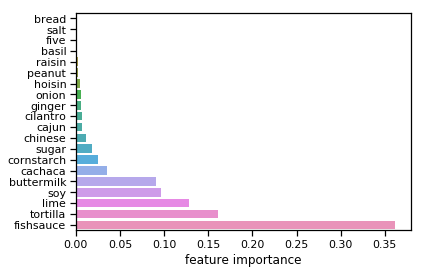

In [26]:
feat_imp = rfr.feature_importances_
feat_imp_ind = np.argsort(feat_imp)[-20:]
s = sns.barplot(x=feat_imp[feat_imp_ind], y=ingredient_names[feat_imp_ind])
dummy = s.set_xlabel('feature importance')

#### PCA

We will use PCA to create new features that are linear combinations of the existing features. It's fast, so it works well with large number of features. In our case, we only need 1000 out of ~2800 original features to explain 95% of the variations. Let's proceed with these 1000 components.

In [27]:
pca = PCA(n_components=1000)
X_train_pca = pca.fit_transform(X_train_tfidf_pd)
X_test_pca = pca.transform(X_test_tfidf_pd)
X_train_pca_pd = pd.DataFrame(X_train_pca)

0.949216563747133


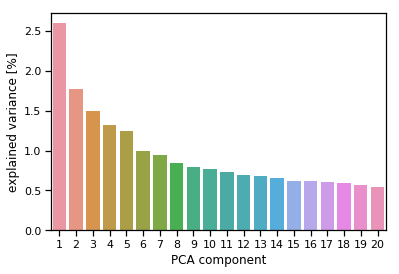

In [28]:
s = sns.barplot(x=np.arange(20)+1, y=pca.explained_variance_ratio_[:20]*100)
s.set_ylabel('explained variance [%]')
s.set_xlabel('PCA component')

print(np.cumsum(pca.explained_variance_ratio_)[-1])

## Predicting the Cuisine

Let's test the following algorithms:

* **Complement Naive Bayes**, a slightly modified version of the Naive Bayes algorithm for multinomially distributed data (multiple classes). According to the documentation, this works better than the standard multinomial Naive Bayes algorithm when we have imbalanced data sets. One relevant hyperparameter is $\alpha$, a smoothing term that appears in the estimation of distribution parameters. NOTE: we cannot use NB with the PCA-transformed data because it requires non-negative data. Running this with the original data yields about 77% accuracy, a good benchmark value to keep in the back of our head.
* **Logistic Regression**
* **Support Vector Machine**
* **Gradient Boosting** is an example of boosting, which is an ensemble method that incrementally improves an initially weak model (e.g., 1 level-deep decision tree, a.k.a. "decision stump") by modeling the residual in each step. We're using sklearn.GBC here but another popular option is XGBoost.
* **Neural Networks**

First we want to test the baseline performance of the algorithms. These models take a long time to train! Although SVC and XGB may achieve better accuracy in the long run with careful hyperparameter tuning, linear regression may be our best bet out of these options given computational feasibility.

In [29]:
algorithms = {'LR':LogisticRegression(solver='saga', multi_class='multinomial'), 'SVC':SVC(gamma='scale'), 'XGB': XGBClassifier(n_estimators=100)}

name_list = algorithms.keys()
for i_n, n in enumerate(name_list):
    X_train_0, X_test_0, y_train_0, y_test_0 = model_selection.train_test_split(X_train_pca, y_train_le, test_size=0.25)
    clf = algorithms[n]
    tic = time.time()
    clf = clf.fit(X_train_0, y_train_0)
    y_pred_0 = clf.predict(X_test_0)
    toc = time.time()
    print(n, "Accuracy: {:.2f}".format(metrics.accuracy_score(y_test_0, y_pred_0)))
    print('Time [s]: {:5.2}'.format(toc-tic))

LR Accuracy: 0.78
Time [s]: 4.9e+01
SVC Accuracy: 0.80
Time [s]: 1.2e+03
XGB Accuracy: 0.70
Time [s]: 6.7e+03


## Optimize the hyperparameters for the algorithm with the best baseline performance.
We will turn again to hyperopt to automatically fine-tune the hyperparameters and see if we can improve the performance of the classifier. LR is much faster (by a factor of ~25) to train than SVC. Let's see if we can tune LR to eke out a better performance.

In [30]:
domain = {
            "penalty": hp.choice("penalty", ['l1', 'l2']),
            "C": hp.loguniform("C",-2,2),
        }

In [31]:
sample(domain)

{'C': 1.9609383226390118, 'penalty': 'l2'}

Save the result as it updates.

In [32]:
outfile = 'lr_saga_trials.csv'
with open(outfile, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['loss', 'acc', 'params', 'train_time'])

In [33]:
def objective(hparams):
    
    tic = timer()
    
    clf = LogisticRegression(**hparams, solver='saga', multi_class='multinomial', max_iter=300)
    cv_score = model_selection.cross_validate(clf, X_train_pca_pd, y_train_le, cv=3, scoring=['neg_log_loss', 'accuracy'], return_train_score=False)
    
    #you want to minimize log loss 
    #sklearn returns negative because its convention is to maximize
    #but hyperopt minimizes so undo the negative
    loss = -np.mean(cv_score['test_neg_log_loss'])
    acc = np.mean(cv_score['test_accuracy'])

    toc = timer()
    
    #write out the results in real time
    with open(outfile, 'w') as f:
        writer = csv.writer(f)
        writer.writerow([loss, acc, hparams, toc-tic])
    
    #so we can monitor the progress!
    pbar.update()

    return {'loss': loss, 'acc': acc, 'hparams': hparams, 'status': STATUS_OK}    

In [34]:
#keep the training information
bayes_trials = Trials()

In [35]:
MAX_EVALS = 50
pbar = tqdm_notebook(total=MAX_EVALS, desc='Hyperopt')

best = fmin(fn=objective, space=domain, algo=tpe.suggest, max_evals=MAX_EVALS, trials=bayes_trials)
pbar.close()

100%|██████████| 50/50 [5:59:37<00:00, 1302.06s/it, best loss: 0.7248442069261651] 



With only 50 trials, the hyperparameter tuning process may not be fully converged. But let's first check our accuracy score.

In [36]:
print(best)

{'C': 4.919201325348731, 'penalty': 1}


Text(0, 0.5, 'loss')

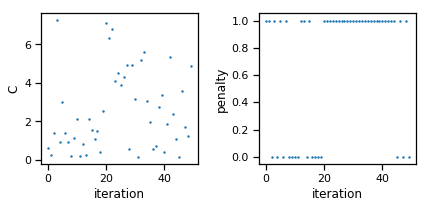

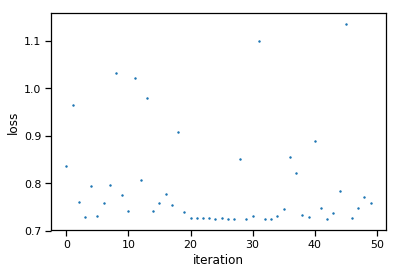

In [37]:
plt.figure(1, figsize=(9,8))
for i_k, k in enumerate(bayes_trials.vals.keys()):
    ax = plt.subplot('33'+str(i_k+1))
    ax.scatter(range(len(bayes_trials.vals[k])), bayes_trials.vals[k], label=k, s=2)
    ax.set_ylabel(' '.join(k.split('_')))
    ax.set_xlabel('iteration')
    plt.tight_layout()

plt.figure(2)
ax = plt.subplot('111')
ax.scatter(range(len(bayes_trials.losses())), bayes_trials.losses(), s=2)
ax.set_xlabel('iteration')
ax.set_ylabel('loss')

In [41]:
print("Accuracy: {:.2f}".format(max([bayes_trials.results[i]['acc'] for i in range(len(bayes_trials.results))])))

Accuracy: 0.78


## SVC after all?

Interestingly, even with hyperparameter optimization, we can't seem to really improve LR's performance. Let's try a very basic grid search with SVC instead. Again, we'll follow Andrew Ng's rule of thumb and use the Gaussian kernel given the size of n and m (n=1000, m~40000).

In [42]:
clf = SVC(kernel='rbf')
gscv = model_selection.GridSearchCV(clf, {'C': [0.1, 1, 5, 20], 'gamma': ['scale', 1.0, 0.1, 0.01]},\
                                scoring='accuracy', cv=3, refit=True, return_train_score=False, n_jobs=-1, verbose=3)
gscv.fit(X_train_pca_pd, y_train_le)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 110.2min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 234.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.1, 1, 5, 20], 'gamma': ['scale', 1.0, 0.1, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='accuracy', verbose=3)

In [43]:
print(gscv.best_score_)
print(gscv.best_params_)

0.8033714932695937
{'C': 5, 'gamma': 'scale'}


## Prediction Output for Submission File

In [45]:
y_true_pred_le = gscv.best_estimator_.predict(X_test_pca).astype('int')
y_true_pred = le.inverse_transform(y_true_pred_le)

X_true_test_withpred = pd.DataFrame({'id': df_test_0.id, 'cuisine': y_true_pred})
X_true_test_withpred.to_csv('svc_gscv_prediction.csv', mode='w', index=False)

## Extra: Neural Network?

Another option is to try a simple shallow neural network. For this, let's try using the entire feature set, rather than the PCA outputs, with some dropout.

In [46]:
X_train_0, X_test_0, y_train_0, y_test_0 = model_selection.train_test_split(X_train_tfidf, y_train_mlb, test_size=0.2)

num_cuisines = y_train_mlb.shape[1]
num_feats = X_train_tfidf.shape[1]

In [47]:
inputs = keras.Input(shape=(num_feats,))

X = keras.layers.Dense(2000, activation=None)(inputs)
X = keras.layers.BatchNormalization()(X)
X = keras.layers.Activation('relu')(X)
X = keras.layers.Dropout(0.8)(X)

X = keras.layers.Dense(2000, activation=None)(inputs)
X = keras.layers.BatchNormalization()(X)
X = keras.layers.Activation('relu')(X)
X = keras.layers.Dropout(0.8)(X)

X = keras.layers.Dense(num_cuisines, activation=None)(X)
X = keras.layers.BatchNormalization()(X)
Y = keras.layers.Activation('softmax')(X)

model = keras.models.Model(inputs=inputs, outputs=Y)
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=['accuracy'])

cb = keras.callbacks.ModelCheckpoint('cooking.weights.best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.fit(X_train_0, y_train_0, epochs=20, batch_size=64, validation_data=(X_test_0, y_test_0), callbacks=[cb, es])

Train on 31796 samples, validate on 7949 samples
Epoch 1/20
31796/31796 [==============================] - 50s 2ms/step - loss: 1.4235 - acc: 0.6613 - val_loss: 0.9499 - val_acc: 0.7766

Epoch 00001: val_acc improved from -inf to 0.77658, saving model to cooking.weights.best.hdf5
Epoch 2/20
31796/31796 [==============================] - 48s 2ms/step - loss: 0.9455 - acc: 0.7704 - val_loss: 0.8023 - val_acc: 0.7863

Epoch 00002: val_acc improved from 0.77658 to 0.78626, saving model to cooking.weights.best.hdf5
Epoch 3/20
31796/31796 [==============================] - 47s 1ms/step - loss: 0.7937 - acc: 0.7907 - val_loss: 0.7457 - val_acc: 0.7903

Epoch 00003: val_acc improved from 0.78626 to 0.79029, saving model to cooking.weights.best.hdf5
Epoch 4/20
31796/31796 [==============================] - 48s 1ms/step - loss: 0.7085 - acc: 0.8066 - val_loss: 0.7193 - val_acc: 0.7931

Epoch 00004: val_acc improved from 0.79029 to 0.79306, saving model to cooking.weights.best.hdf5
Epoch 5/20
317

## Future work / Closing thoughts

The hyperparameter tuning was really slow. Beyond hyperparameter tuning/LR itself, other algorithms could have performed better. Ideally, we would have optimized SVM more extensively.

The distribution of cuisines shows that the classes are moderately imbalanced (e.g., many times more italian cuisine than irish cuisine). Would something like oversampling help here?